# Measuring differences in aSMA and CD21 between HVCD,MCD and R

CD21: For whole images, measure both pixel area and pixel intensity. Also record how much of image is germinal center.
aSMA: For whole images, measure pixel area
    - This stain could be difficult because it was only run for R2, which is a weird sample

For pixel area:
    1. load image, apply some threshold
    2. quantitate signal...
        - Convex hull of tissue, how much area is CD21+
        - How many cells belong to germinal center motif
        - CD21+ area inside convex hull of clustered germinal centers

For pixel intensity:
    - need to find way to normalize signal...
    
Potentially, run broad LDA (n=5) and quantify metrics within neighborhoods?

In [1]:
import os
import re
import tifffile as tff
import numpy as np
import anndata as ad
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from skimage.morphology import disk
from skimage.filters import threshold_otsu, rank, threshold_local
import hdbscan
from sklearn.preprocessing import StandardScaler
from scipy.spatial import ConvexHull, convex_hull_plot_2d
from skimage.draw import polygon2mask
import tqdm
from skimage.filters.rank import entropy
from skimage.exposure import histogram
from PIL import Image, ImageStat

import scipy as sci
# import umap
# import leidenalg as la
# import igraph as ig
# from sklearn.manifold import MDS
# from sklearn.cluster import DBSCAN
# from sklearn.neighbors import radius_neighbors_graph

In [2]:
root_dir = "../../../outs/neighborhood_analysis"
dat_dir = [d for d in os.listdir(root_dir) if 'reg' in d and bool(re.match("R|MCD|HVCD",d))]

In [3]:
def concat_adata(pl):
    keep_p = []
    for p in pl:
        if not os.path.isfile(os.path.join(root_dir,p,'all_tiles_failed.token')):
            keep_p.append(p)
    dat = list(map(lambda x: ad.read_h5ad(os.path.join(root_dir, x, 'gated_dat.h5ad')), keep_p))
    # organize the markers consistently
    markers = list(map(lambda x: x.var_names.tolist(), dat))
    common_markers = set.intersection(*list(map(set,markers)))
    for a in dat:
        markeri = list(map(lambda x: int(np.where(x == a.var_names)[0]), common_markers))
        a = a[:,markeri]
    adata = ad.concat(dat, label="region", keys=keep_p, index_unique="_")
    return(adata)

In [3]:
def get_image_data(n):
    img = tff.TiffFile("../../forQuPath/Data/"+n+"/input_codex.qptiff")
    if bool(re.match("R1|K1|K2",n)):
        channels = "channelNames"
    elif bool(re.match("HVCD1|MCD1|MCD3",n)):
        channels = "channelNames_cohort2"
    elif bool(re.match("HVCD2|MCD4|R2",n)):
        channels = "channelNames_cohort3"
    elif bool(re.match("K3",n)):
        channels = "channelNames_cohort4"
    m_list = pd.read_table("../../forQuPath/"+channels+".txt", header=None)
    marker_i = np.where(m_list[0]=="CD21")[0]
    dat = img.series[0].pages[int(marker_i)].asarray()
    return dat

### Testing area estimation
local OTSU takes too long.

Global OTSU seems to work fine.

For area, how to find tissue pixels? Average across channels?
    - applying mean takes waayyy too long

In [132]:
s = 'MCD3_reg2'
img = tff.TiffFile("../../forQuPath/Data/"+s+"/input_codex.qptiff")
m_list = pd.read_table("../../forQuPath/channelNames_cohort2.txt", header=None)
marker_i = np.where(m_list[0]=="CD21")[0]

In [133]:
# dat = img.series[0].pages[int(marker_i)].asarray()
dat = img.series[0].pages[1].asarray()

In [127]:
# radius = 100
# footprint = disk(radius)
# local_otsu = rank.otsu(dat, footprint)
global_thresh = threshold_otsu(dat)

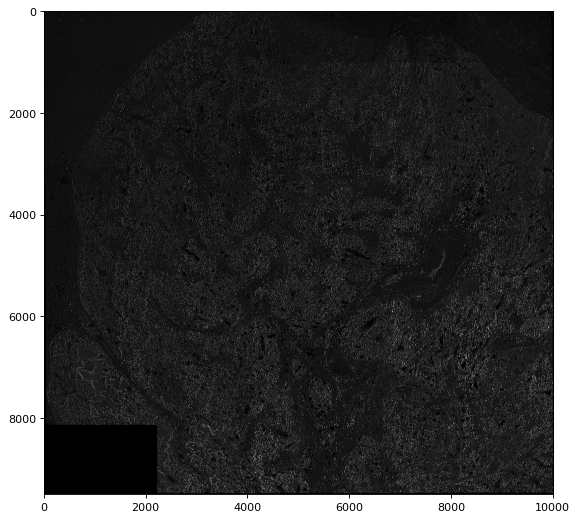

In [134]:
figure(figsize=(12, 8), dpi=80)
# plt.imshow(dat >= global_thresh, cmap='gray')
plt.imshow(dat, cmap='gray')

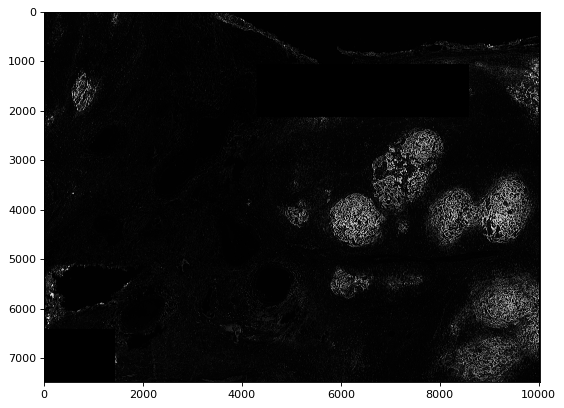

In [17]:
plt.figure(figsize=(8, 8), dpi=80)
test = img.series[0].pages[marker_i[0]].asarray()
plt.imshow(test, cmap='gray')

## Defining regions
Run LDA on all data, 5 categories
The intention is try and define germinal centers

Can't run LDA in this notebook, going to define the neighborhoods in another script, then reimport...

Germinal centers seem to be motif 0

Approach:
1. Cluster cells into germinal centers?
    - Use sklearn MDS... and/or scikit-learn kneighbors 
        - MDS is way too slow and memory intense
    - run leiden clustering dimensions... maybe try DBSCAN first (scikit-learn) and/or leiden clustering on neighbor graph?
2. For each germinal center find convex hull
3. Apply polygon mask to image data (e.g. pixel area) 

In [216]:
adata=concat_adata(dat_dir)
adata

AnnData object with n_obs × n_vars = 3895114 × 38
    obs: 'Unnamed: 0', 'orig.ident', 'nCount_originalexp', 'nFeature_originalexp', 'Reg', 'Tile.Row', 'Tile.Col', 'Tile.Z', 'In.Tile.Y', 'In.Tile.X', 'Absolute.Y', 'Absolute.X', 'Cell.Size', 'n_genes_by_counts', 'total_counts', 'nCount_raw', 'nFeature_raw', 'cell_type_pred_knn', 'cell_type_pred_knn_prob', 'motif', 'index_info', 'new_pheno', 'region'

In [7]:
# going out for LDA...
# adata.write('all_regions_dat.h5ad')

# coming back in...
adata = ad.read_h5ad('all_regions_dat.h5ad')

### Testing approach

In [114]:
test_dat = adata.obs.loc[(adata.obs['region']=="MCD3_reg1") & (adata.obs['motif']=="Motif_0"), ['Absolute.X', 'Absolute.Y']].copy()
scaled_dat = StandardScaler().fit_transform(test_dat)
test_dat.shape

(2454, 2)

In [118]:
labels = hdbscan.HDBSCAN(
    min_samples=10,
    min_cluster_size=20,
    alpha = 1.,
    algorithm = 'best',
    cluster_selection_method = 'eom',
).fit_predict(scaled_dat)

In [119]:
keep = pd.Series(labels).value_counts().index[pd.Series(labels).value_counts()>300]
labels_filter = list(map(lambda x: x not in keep, labels))
labels[labels_filter] = -1

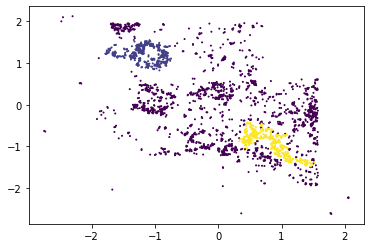

In [120]:
# plt.scatter(test_dat[:,0], -1*test_dat[:,1], s=1, c=labels*labels_filter)
plt.scatter(scaled_dat[:,0], -1*scaled_dat[:,1], s=1, c=labels)

In [29]:
test_dat['cluster'] = labels

In [30]:
# getting the convex hulls
hull_list = []
for c in test_dat['cluster'].unique():
    if c == -1:
        continue
    p = test_dat.loc[test_dat.cluster == c, ['Absolute.X', 'Absolute.Y']].to_numpy()
    hull_list.append(ConvexHull(p))

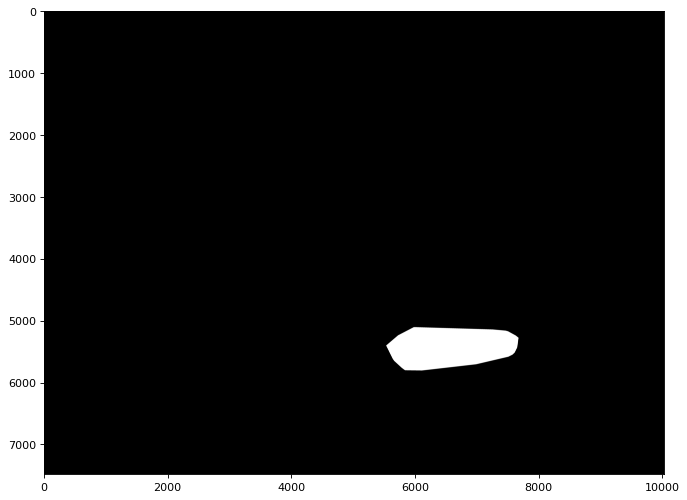

In [60]:
# image_shape = dat.shape
image_shape = img.series[0].pages[0].shape
mask = polygon2mask(image_shape, np.flip(hull_list[5].points[hull_list[5].vertices], 1))
# mask = polygon2mask(image_shape, [[3000,4000],[3000,6000],[5000,4000],[5000,6000]])
dat_ = np.zeros(image_shape)
# dat_[mask] = dat[mask]
dat_[mask] = 255
figure(figsize=(10, 8), dpi=80)
# plt.imshow(dat_ >= global_thresh, cmap='gray')
plt.imshow(dat_, cmap='gray')

## Collecting the statistics

maybe separately collect stats from R, HVCD, and MCD

Metrics:
No. germ. center cells
No. of germ. clusters
CD21 area (total)
avg. cell CD21 signal  (total)
No. of germ. clusters, with positive CD21
Avg. cluster size
Avg. CD21 area (cluster)
avg. cell CD21 singal (cluster)
Avg. entropy (cluster)

In [4]:
adata = ad.read_h5ad('all_regions_dat.h5ad')

In [5]:
stat_names = ['pct. germ. cells',
              'CD21 cell signal (total)',
              'CD21 area (total)',
              'No. germ. clusters',
              'No. CD21+ germ. clusters',
              'avg. cluster area',
              'avg. CD21 area (cluster)',
              'avg. entropy (cluster)',
              'avg. entropy threshold (cluster)',
              # 'avg. entropy threshold (pixel)',
              'avg. CD21 cell signal (cluster)',
              'avg. CD21 brightness (cluster)',
              'shannon index'
             ]

In [8]:
def calc_entropy(img_dat, mask, h, t):
    hull_entropy = entropy(img_dat, footprint=disk(5), mask=mask)
    x_max = int(h.points[:,0].max())
    x_min = int(h.points[:,0].min())
    y_max = int(h.points[:,1].max())
    y_min = int(h.points[:,1].min())
    hull_img = img_dat[x_min:x_max, y_min:y_max]
    test_foll = hull_entropy[x_min:x_max, y_min:y_max]
    # entropy_stat = np.sqrt(np.sum(test_foll[hull_img>t]**2)/np.sum(hull_img>t))
    entropy_stat = np.sum(test_foll)/np.sum(hull_img>t)
    # entropy_stat = np.sqrt(np.sum(test_foll[hull_img>0]**2)/np.sum(hull_img>0))
    return entropy_stat

In [9]:
def get_image_stat(img_dat, hull_dict, cell_dat, t, adata=adata):
    img_stats = []
    stat_array = None
    image_shape = img_dat.shape
    for c, h in hull_dict.items():
        poly_area = h.volume
        # mask = polygon2mask(image_shape, np.flip(h.points[h.vertices],1)) 
        mask = polygon2mask(image_shape, h.points[h.vertices]) #updated, removed flip
        cd21_area = np.sum(img_dat[mask] >= t)
        # # test if is germinal center?
        # if cd21_area/poly_area < 0.01: # probably need to tune this number for each method, or just skip for method 2
        #     continue
        if cd21_area == 0:
            continue
        # entropy from theshold values
        #    -the skimage method 
        e1 = calc_entropy(img_dat, mask, h, t)
        # e2 = np.sqrt(np.sum(foll_entropy**2)/len(foll_entropy)) # number of pixels
        
        #    -the PIL method
        #    threshold
        # t_dat = np.zeros(image_shape)
        # t_dat[(img_dat>t)] = 255
        # img = Image.fromarray(t_dat)
        # if img.mode == 'F':
        #     img = img.convert('L')
        dat_ = np.zeros(image_shape)
        dat_[mask] = 255
        img_mask = Image.fromarray(np.uint8(dat_), mode='L')
        # e1 = img.entropy(mask=img_mask)
        #    raw image
        img = Image.fromarray(img_dat)
        entropy_stat = img.entropy(mask=img_mask)
        
        # cell signal
        cell_i = cell_dat.index[cell_dat['cluster'] == c] 
        signal_stat = adata[cell_i, "CD21"].X.toarray().mean()
        # brightness
        img_stat = ImageStat.Stat(img, mask=img_mask)
        bright_stat = img_stat.rms[0]
        # put it all together
        img_stats.append([poly_area, cd21_area/poly_area, entropy_stat, e1, signal_stat, bright_stat])
    if len(img_stats) > 0:
        stat_array = np.vstack(img_stats)
    return stat_array

In [164]:


t_dat = np.zeros(image_shape)
t_dat[img_dat >= t] = 1
img = Image.fromarray(t_dat, mode='1')
dat_ = np.zeros(image_shape)
dat_[mask] = 1
img_mask = Image.fromarray(np.uint8(dat_), mode='1')
e1 = img.entropy(mask=img_mask)
print(e1)
print(entropy_stat)

0.04898319834963724
6.453802651128154


In [36]:
img_stats = []
t = global_thresh
# t=0
stat_array = None
image_shape = img_dat.shape
h = hull_dict[3]
poly_area = h.volume
mask = polygon2mask(image_shape, h.points[h.vertices])
cd21_area = np.sum(img_dat[mask] >= t)
img = Image.fromarray(img_dat)
dat_ = np.zeros(image_shape)
dat_[mask] = 255
img_mask = Image.fromarray(np.uint8(dat_), mode='L')
entropy_stat = img.entropy(mask=img_mask)

t_dat = np.zeros(image_shape)
t_dat[(img_dat > t)] = 255
img = Image.fromarray(t_dat)
img = img.convert('L')
dat_ = np.zeros(image_shape)
dat_[mask] = 255
img_mask = Image.fromarray(np.uint8(dat_), mode='L')
e1 = img.entropy(mask=img_mask)
print(entropy_stat)
print(e1)

6.500187766238025
0.6606006155164432


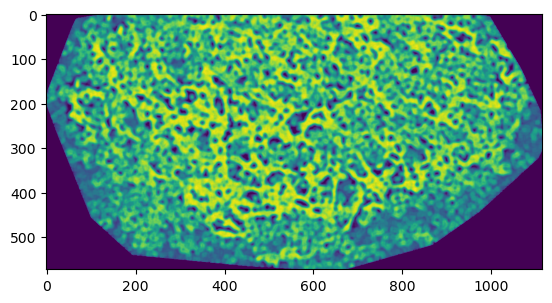

In [34]:
# t_dat = np.zeros(image_shape)
# t_dat[(img_dat > t)] = 1
hull_entropy = entropy(img_dat, footprint=disk(5), mask=mask)
x_max = int(h.points[:,0].max())
x_min = int(h.points[:,0].min())
y_max = int(h.points[:,1].max())
y_min = int(h.points[:,1].min())
hull_img = img_dat[x_min:x_max, y_min:y_max]
test_foll = hull_entropy[x_min:x_max, y_min:y_max]
plt.imshow(test_foll)

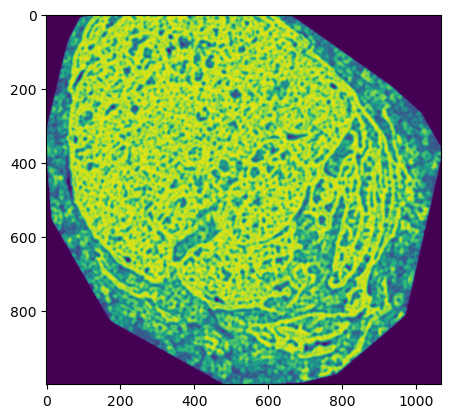

In [40]:
# t_dat = np.zeros(image_shape)
# t_dat[(img_dat > t)] = 1
hull_entropy = entropy(img_dat, footprint=disk(5), mask=mask)
x_max = int(h.points[:,0].max())
x_min = int(h.points[:,0].min())
y_max = int(h.points[:,1].max())
y_min = int(h.points[:,1].min())
hull_img = img_dat[x_min:x_max, y_min:y_max]
test_foll = hull_entropy[x_min:x_max, y_min:y_max]
plt.imshow(test_foll)

In [11]:
scharr = np.array([[ -3-3j, 0-10j,  +3 -3j],
                   [-10+0j, 0+ 0j, +10 +0j],
                   [ -3+3j, 0+10j,  +3 +3j]])
x_max = int(h.points[:,0].max())
x_min = int(h.points[:,0].min())
y_max = int(h.points[:,1].max())
y_min = int(h.points[:,1].min())
test_foll = img_dat[x_min:x_max, y_min:y_max]
grad = sci.signal.convolve2d(test_foll, scharr, boundary='symm', mode='same')

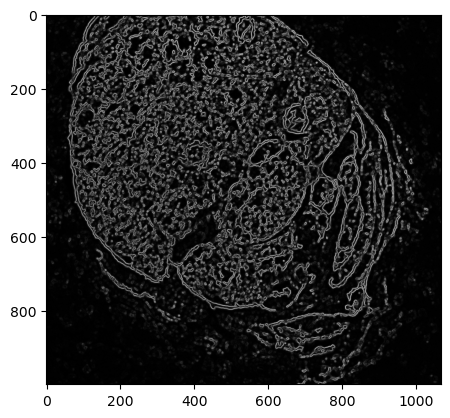

In [16]:
plt.imshow(np.absolute(grad), cmap='gray')

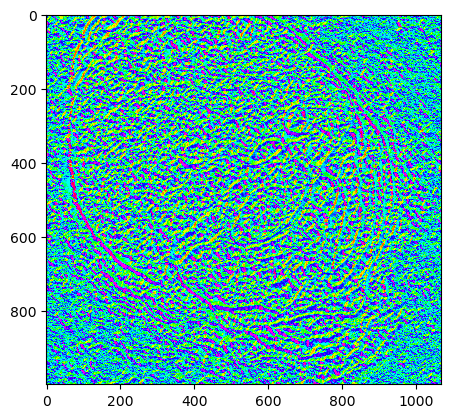

In [18]:
plt.imshow(np.angle(grad), cmap='hsv')

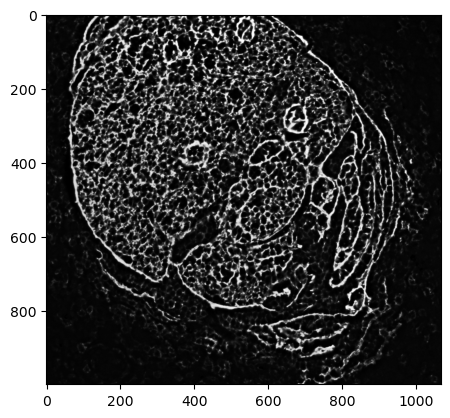

In [17]:
plt.imshow(test_foll, cmap='gray')

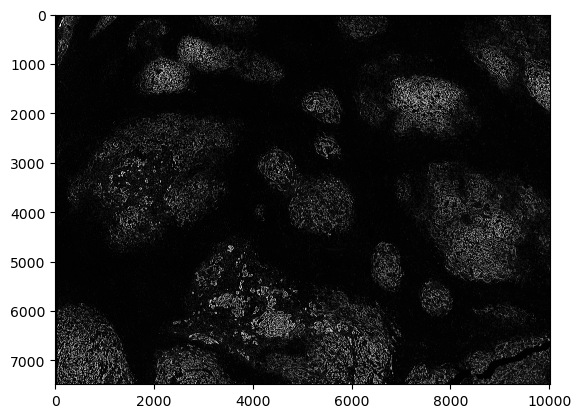

In [30]:
# img = Image.fromarray(img_dat)
plt.imshow(img_dat, cmap='gray')

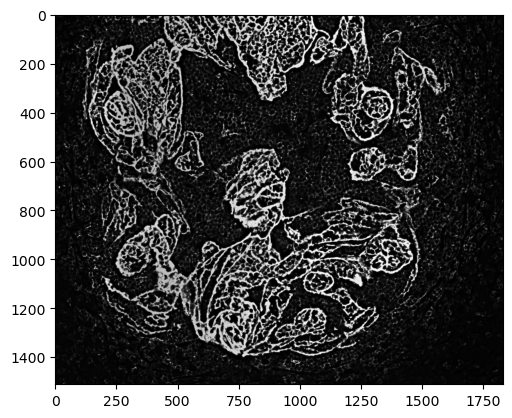

In [67]:
# x_cnstr = np.apply_along_axis(lambda x: np.where(x), 1, mask)
# y_cnstr = np.apply_along_axis(lambda x: np.where(x), 0, mask)
x_max = int(h.points[:,0].max())
x_min = int(h.points[:,0].min())
y_max = int(h.points[:,1].max())
y_min = int(h.points[:,1].min())
pdata = img_dat[x_min:x_max, y_min:y_max]
plt.imshow(pdata, cmap='gray')

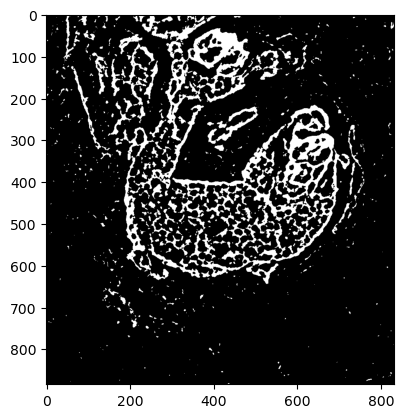

In [65]:
plt.imshow(t_dat[x_min:x_max, y_min:y_max], cmap='gray')

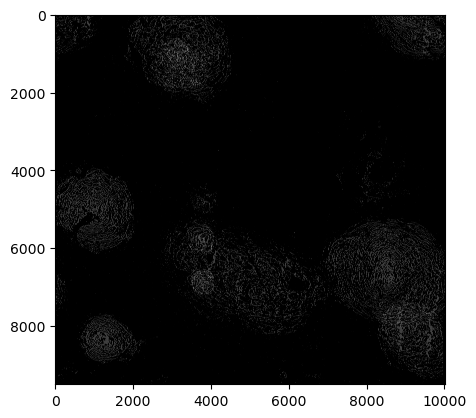

In [234]:
# plt.imshow(pdata>t, cmap='gray')
t_dat = np.zeros(image_shape)
t_dat[(img_dat>t)] = 255
img = Image.fromarray(t_dat.astype(int), mode='I')
plt.imshow(img, cmap='gray')

255.0

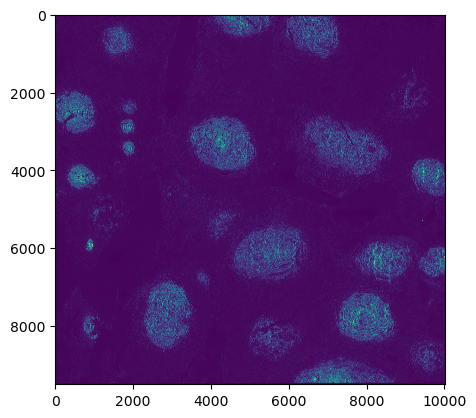

In [212]:
plt.imshow(img_dat)

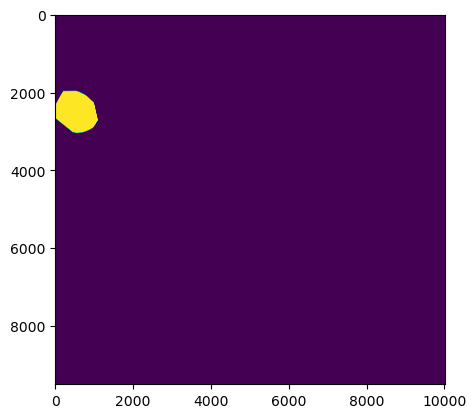

In [185]:
plt.imshow(mask)

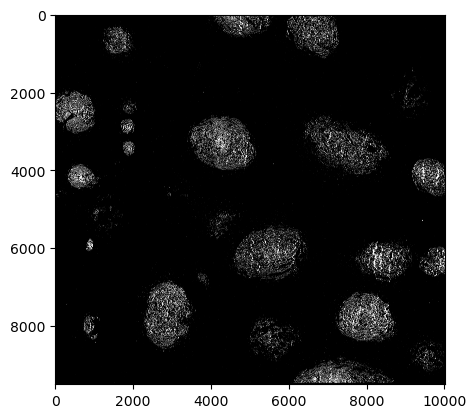

In [128]:
# idx = img_dat[mask] >= t
# pdata = np.ma.array(img_dat, mask = mask)
pdata = np.zeros(image_shape)
pdata[img_dat >= t] = 1
plt.imshow(pdata, cmap='gray')

In [10]:
def getFollicleShapes(adata):
    coords = adata[['Absolute.Y', 'Absolute.X']].to_numpy() # should it be X,Y or Y,X ????
    # coords = coords[adata.obs.motif.isin(['Motif_2', 'Motif_4']),:]
    
    # getting the follicles
    clustered = []
    follicle_sets = []
    for i in range(coords.shape[0]):
        if i not in clustered:
            i_dist = np.linalg.norm(coords[i]-coords, axis=1)
            i_neighbor = np.where(i_dist < 30)[0].tolist()
            # should we check whether any of the neighbors are in the clustered list?
            # i_neighbor = i_neighbor[~list(map(lambda i_: i_ in clustered, i_neighbor))]
            clustered.extend(i_neighbor)
            
            new_cl_token = 1
            fs_hits = [fi for fi in range(len(follicle_sets)) if len(set(follicle_sets[fi]).intersection(i_neighbor)) > 0]
            if len(fs_hits) > 0:
                cell_set = []
                for fi in sorted(fs_hits, reverse=True):
                    cell_set.extend(follicle_sets[fi])
                    follicle_sets.pop(fi)
                cell_set = set(cell_set).union(i_neighbor)
                follicle_sets.append(cell_set)
            else:
                follicle_sets.append(i_neighbor)
    
    
    # filtering follicles
    f_clust = []
    keep_i = []
    cl_i = 1
    for fs in follicle_sets:
        if len(fs) > 200:
            f_clust.extend(np.repeat(cl_i, len(fs)))
            keep_i.extend(fs)
            cl_i += 1
    follicle_filt = pd.DataFrame({'cluster':f_clust,
                                 'celli':keep_i})

    hull_dict = {}
    for f in follicle_filt.cluster.unique():
        coords_test = coords[follicle_filt.celli.loc[follicle_filt.cluster==f].values,:]
        foll_hull = ConvexHull(coords_test)
        hull_dict[f] = foll_hull
    
    return hull_dict, follicle_filt

### HVCD

In [9]:
hvcd_res = {}
[ii for ii in dat_dir if 'HVCD' in ii]

['HVCD2_reg1',
 'HVCD1_reg3',
 'HVCD2_reg3',
 'HVCD1_reg1',
 'HVCD2_reg2',
 'HVCD1_reg4',
 'HVCD2_reg5',
 'HVCD1_reg2',
 'HVCD2_reg4']

In [35]:
i = 'HVCD2_reg2'
reg_dat = adata.obs.loc[adata.obs['region']==i, :].copy()
num_cells = reg_dat.shape[0]
reg_area = ConvexHull(reg_dat[['Absolute.X', 'Absolute.Y']].to_numpy()).volume
total_cd21_signal = adata[adata.obs['region']==i, "CD21"].X.toarray().mean()

# germ. center stats
test_dat = reg_dat.loc[reg_dat.motif.isin(['Motif_2', 'Motif_4']), ['Absolute.X', 'Absolute.Y']] #updated!
num_germ_cells = test_dat.shape[0]
hull_dict, foll_df = getFollicleShapes(test_dat)
test_dat = test_dat.iloc[foll_df.celli, :]
test_dat['cluster'] = foll_df.cluster.values
img_dat = get_image_data(i)
global_thresh = threshold_otsu(img_dat)
cd21_total_area = np.sum(img_dat > global_thresh)/reg_area

/tmp/ipykernel_2518468/445785896.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dat = img.series[0].pages[int(marker_i)].asarray()


In [45]:
get_image_stat(img_dat, hull_dict, test_dat, global_thresh)

array([[ 1.58833563e+05,  1.28562249e-01,  6.28582894e+00,
        -0.00000000e+00,  5.69642878e+00,  6.25839655e+01],
       [ 5.54875814e+05,  1.65218951e-01,  6.28023264e+00,
        -0.00000000e+00,  5.53715754e+00,  7.05711321e+01],
       [ 2.37072103e+06,  1.72202041e-01,  6.38177693e+00,
        -0.00000000e+00,  5.68512440e+00,  7.63598635e+01],
       [ 1.86040774e+06,  1.44021654e-01,  6.07853747e+00,
        -0.00000000e+00,  5.50514889e+00,  7.27053251e+01],
       [ 4.03912935e+06,  1.59185791e-01,  6.29873444e+00,
        -0.00000000e+00,  5.53816700e+00,  7.31630617e+01],
       [ 3.26956877e+06,  1.71107886e-01,  6.41666807e+00,
        -0.00000000e+00,  5.64624166e+00,  7.55990149e+01],
       [ 1.93659103e+05,  3.71993875e-02,  5.15793609e+00,
        -0.00000000e+00,  4.87488461e+00,  3.55284016e+01]])

In [19]:
hvcd_res = {}
for i in tqdm.tqdm([ii for ii in dat_dir if 'HVCD' in ii]):
    # regional stats
    reg_dat = adata.obs.loc[adata.obs['region']==i, :].copy()
    num_cells = reg_dat.shape[0]
    reg_area = ConvexHull(reg_dat[['Absolute.X', 'Absolute.Y']].to_numpy()).volume
    total_cd21_signal = adata[adata.obs['region']==i, "CD21"].X.toarray().mean()
    
    # germ. center stats
    test_dat = reg_dat.loc[reg_dat.motif.isin(['Motif_2', 'Motif_4', 'Motif_11']), ['Absolute.X', 'Absolute.Y']] #updated!
    num_germ_cells = test_dat.shape[0]
    
    ### METHOD 1
    # # cluster the germinal center cells
    # scaled_dat = StandardScaler().fit_transform(test_dat) #update, moved line
    # labels = hdbscan.HDBSCAN(
    #     min_samples=1, 
    #     min_cluster_size=20).fit_predict(scaled_dat)
    # keep = pd.Series(labels).value_counts().index[pd.Series(labels).value_counts()>300]
    # labels_filter = list(map(lambda x: x not in keep, labels))
    # labels[labels_filter] = -1
    # test_dat['cluster'] = labels
    # # get the germinal center polygons
    # hull_dict = {}
    # for c in test_dat['cluster'].unique():
    #     if c == -1:
    #         continue
    #     p = test_dat.loc[test_dat.cluster == c, ['Absolute.X', 'Absolute.Y']].to_numpy()
    #     hull_dict[c] = ConvexHull(p)

    ### METHOD 2
    hull_dict, foll_df = getFollicleShapes(test_dat)
    test_dat = test_dat.iloc[foll_df.celli, :]
    test_dat['cluster'] = foll_df.cluster.values
    
    # continuing with stats
    img_dat = get_image_data(i)
    global_thresh = threshold_otsu(img_dat)
    cd21_total_area = np.sum(img_dat > global_thresh)/reg_area
    cluster_stats = get_image_stat(img_dat, hull_dict, test_dat, global_thresh)
    if cluster_stats is not None:
        num_cluster_pos = cluster_stats.shape[0]
        cluster_means = np.apply_along_axis(np.median, 0, cluster_stats).tolist()
    else:
        num_cluster_pos = 0
        cluster_means = np.repeat(0, 6).tolist()
    # shannon index
    ct_dat = reg_dat.new_pheno.loc[test_dat.index]
    s_index = 0
    for ct in ct_dat.unique():
        p_i = (ct_dat==ct).sum()/ct_dat.size
        sh_stat = -1*p_i*np.log(p_i)
        s_index += sh_stat
    cluster_means.append(s_index)
    hvcd_res[i] = [num_germ_cells/num_cells,
                   total_cd21_signal,
                   cd21_total_area,
                   len(hull_dict),
                   num_cluster_pos]
    hvcd_res[i].extend(cluster_means) 
    

  0%|          | 0/9 [00:00<?, ?it/s]/tmp/ipykernel_1389883/445785896.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dat = img.series[0].pages[int(marker_i)].asarray()
 11%|█         | 1/9 [01:05<08:40, 65.07s/it]/tmp/ipykernel_1389883/445785896.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dat = img.series[0].pages[int(marker_i)].asarray()
 22%|██▏       | 2/9 [04:49<18:31, 158.83s/it]/tmp/ipykernel_1389883/445785896.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Depreca

In [20]:
hvcd_df = pd.DataFrame(hvcd_res).T
hvcd_df.columns = stat_names
hvcd_df

,pct. germ. cells,CD21 cell signal (total),CD21 area (total),No. germ. clusters,No. CD21+ germ. clusters,avg. cluster area,avg. CD21 area (cluster),avg. entropy (cluster),avg. entropy threshold (cluster),avg. CD21 cell signal (cluster),avg. CD21 brightness (cluster),shannon index
HVCD2_reg1,0.436501,4.986036,0.048285,7.0,7.0,1.860408e+06,0.144022,6.147034,26.692631,5.537158,70.571132,1.015360
HVCD1_reg3,0.316039,4.639822,0.025578,24.0,22.0,7.641553e+05,0.091706,5.930741,44.595789,5.388341,46.384481,1.049571
HVCD2_reg3,0.398867,4.551388,0.032285,11.0,11.0,9.950647e+05,0.105503,5.518179,36.147079,5.410795,62.383732,0.946571
HVCD1_reg1,0.307701,4.740357,0.029684,22.0,22.0,6.271810e+05,0.103016,5.956831,39.751645,5.267489,48.122650,0.945060
HVCD2_reg2,0.222775,4.627542,0.023819,14.0,14.0,8.231095e+05,0.120382,5.942821,35.633909,5.349458,61.811057,1.143619
HVCD1_reg4,0.322920,4.692322,0.039502,24.0,24.0,4.391381e+05,0.121551,5.971616,35.634595,5.513576,52.405235,0.840820
HVCD2_reg5,0.249634,4.044829,0.017605,11.0,11.0,1.004807e+06,0.052676,4.677182,62.251969,4.885189,41.861707,0.910581
HVCD1_reg2,0.255418,4.705625,0.038167,24.0,24.0,5.848119e+05,0.173476,6.556241,27.322928,5.597600,60.613309,0.865658
HVCD2_reg4,0.400635,4.512230,0.055491,14.0,14.0,1.072788e+06,0.108868,5.554841,36.222231,5.186604,63.295027,0.942712


### R

In [21]:
r_res = {}
for i in tqdm.tqdm([ii for ii in dat_dir if 'R' in ii]):
    # regional stats
    reg_dat = adata.obs.loc[adata.obs['region']==i, :].copy()
    num_cells = reg_dat.shape[0]
    reg_area = ConvexHull(reg_dat[['Absolute.X', 'Absolute.Y']].to_numpy()).volume
    total_cd21_signal = adata[adata.obs['region']==i, "CD21"].X.toarray().mean()
    
    # germ. center stats
    test_dat = reg_dat.loc[reg_dat.motif.isin(['Motif_2', 'Motif_4', 'Motif_11']), ['Absolute.X', 'Absolute.Y']]
    num_germ_cells = test_dat.shape[0]
    ### METHOD 1
    # # cluster the germinal center cells
    # scaled_dat = StandardScaler().fit_transform(test_dat) #update, moved line
    # labels = hdbscan.HDBSCAN(
    #     min_samples=1, 
    #     min_cluster_size=20).fit_predict(scaled_dat)
    # keep = pd.Series(labels).value_counts().index[pd.Series(labels).value_counts()>300]
    # labels_filter = list(map(lambda x: x not in keep, labels))
    # labels[labels_filter] = -1
    # test_dat['cluster'] = labels
    # # get the germinal center polygons
    # hull_dict = {}
    # for c in test_dat['cluster'].unique():
    #     if c == -1:
    #         continue
    #     p = test_dat.loc[test_dat.cluster == c, ['Absolute.X', 'Absolute.Y']].to_numpy()
    #     hull_dict[c] = ConvexHull(p)

    ### METHOD 2
    hull_dict, foll_df = getFollicleShapes(test_dat)
    test_dat = test_dat.iloc[foll_df.celli, :]
    test_dat['cluster'] = foll_df.cluster.values
    
    # continuing with stats
    img_dat = get_image_data(i)
    global_thresh = threshold_otsu(img_dat)
    cd21_total_area = np.sum(img_dat > global_thresh)/reg_area
    cluster_stats = get_image_stat(img_dat, hull_dict, test_dat, global_thresh)
    if cluster_stats is not None:
        num_cluster_pos = cluster_stats.shape[0]
        cluster_means = np.apply_along_axis(np.median, 0, cluster_stats).tolist() #changed mean to median
    else:
        num_cluster_pos = 0
        cluster_means = np.repeat(0, 6).tolist()
    # shannon index
    ct_dat = reg_dat.new_pheno.loc[test_dat.index]
    s_index = 0
    for ct in ct_dat.unique():
        p_i = (ct_dat==ct).sum()/ct_dat.size
        sh_stat = -1*p_i*np.log(p_i)
        s_index += sh_stat
    cluster_means.append(s_index)
    r_res[i] = [num_germ_cells/num_cells,
                   total_cd21_signal,
                   cd21_total_area,
                   len(hull_dict),
                   num_cluster_pos]
    r_res[i].extend(cluster_means) 
    

  0%|          | 0/4 [00:00<?, ?it/s]/tmp/ipykernel_1389883/445785896.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dat = img.series[0].pages[int(marker_i)].asarray()
 25%|██▌       | 1/4 [04:03<12:10, 243.56s/it]/tmp/ipykernel_1389883/445785896.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dat = img.series[0].pages[int(marker_i)].asarray()
 50%|█████     | 2/4 [08:03<08:03, 241.54s/it]/tmp/ipykernel_1389883/445785896.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprec

In [22]:
r_df = pd.DataFrame(r_res).T
r_df.columns = stat_names
r_df

,pct. germ. cells,CD21 cell signal (total),CD21 area (total),No. germ. clusters,No. CD21+ germ. clusters,avg. cluster area,avg. CD21 area (cluster),avg. entropy (cluster),avg. entropy threshold (cluster),avg. CD21 cell signal (cluster),avg. CD21 brightness (cluster),shannon index
R1_reg3,0.522910,4.386757,0.053149,20.0,20.0,564492.992062,0.086530,5.198158,43.149562,4.912420,49.574796,1.311341
R2_reg1,0.152779,4.548422,0.005689,17.0,17.0,409180.398565,0.112233,6.038359,38.808867,5.534575,56.554612,1.016168
R1_reg2,0.263772,4.245331,0.026749,9.0,9.0,411464.195502,0.114107,5.469550,35.478619,4.891131,59.553413,1.412997
R1_reg1,0.339722,3.955271,0.026058,24.0,24.0,771264.323324,0.066039,4.932628,55.632621,4.672813,41.215548,1.297556


### MCD

In [23]:
mcd_res = {}
for i in tqdm.tqdm([ii for ii in dat_dir if 'MCD' in ii]):
    # regional stats
    reg_dat = adata.obs.loc[adata.obs['region']==i, :].copy()
    num_cells = reg_dat.shape[0]
    reg_area = ConvexHull(reg_dat[['Absolute.X', 'Absolute.Y']].to_numpy()).volume
    total_cd21_signal = adata[adata.obs['region']==i, "CD21"].X.toarray().mean()
    
    # germ. center stats
    test_dat = reg_dat.loc[reg_dat.motif.isin(['Motif_2', 'Motif_4', 'Motif_11']), ['Absolute.X', 'Absolute.Y']]
    num_germ_cells = test_dat.shape[0]
    ### METHOD 1
    # # cluster the germinal center cells
    # scaled_dat = StandardScaler().fit_transform(test_dat) #update, moved line
    # labels = hdbscan.HDBSCAN(
    #     min_samples=1, 
    #     min_cluster_size=20).fit_predict(scaled_dat)
    # keep = pd.Series(labels).value_counts().index[pd.Series(labels).value_counts()>300]
    # labels_filter = list(map(lambda x: x not in keep, labels))
    # labels[labels_filter] = -1
    # test_dat['cluster'] = labels
    # # get the germinal center polygons
    # hull_dict = {}
    # for c in test_dat['cluster'].unique():
    #     if c == -1:
    #         continue
    #     p = test_dat.loc[test_dat.cluster == c, ['Absolute.X', 'Absolute.Y']].to_numpy()
    #     hull_dict[c] = ConvexHull(p)

    ### METHOD 2
    hull_dict, foll_df = getFollicleShapes(test_dat)
    test_dat = test_dat.iloc[foll_df.celli, :]
    test_dat['cluster'] = foll_df.cluster.values
    
    # continuing with stats
    img_dat = get_image_data(i)
    global_thresh = threshold_otsu(img_dat)
    cd21_total_area = np.sum(img_dat > global_thresh)/reg_area
    cluster_stats = get_image_stat(img_dat, hull_dict, test_dat, global_thresh)
    if cluster_stats is not None:
        num_cluster_pos = cluster_stats.shape[0]
        cluster_means = np.apply_along_axis(np.median, 0, cluster_stats).tolist() #changed mean to median
    else:
        num_cluster_pos = 0
        cluster_means = np.repeat(0, 6).tolist()
    # shannon index
    ct_dat = reg_dat.new_pheno.loc[test_dat.index]
    s_index = 0
    for ct in ct_dat.unique():
        p_i = (ct_dat==ct).sum()/ct_dat.size
        sh_stat = -1*p_i*np.log(p_i)
        s_index += sh_stat
    cluster_means.append(s_index)
    mcd_res[i] = [num_germ_cells/num_cells,
                   total_cd21_signal,
                   cd21_total_area,
                   len(hull_dict),
                   num_cluster_pos]
    mcd_res[i].extend(cluster_means) 
    

  0%|          | 0/11 [00:00<?, ?it/s]/tmp/ipykernel_1389883/445785896.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dat = img.series[0].pages[int(marker_i)].asarray()
  9%|▉         | 1/11 [01:49<18:12, 109.20s/it]/tmp/ipykernel_1389883/445785896.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dat = img.series[0].pages[int(marker_i)].asarray()
 18%|█▊        | 2/11 [02:49<12:04, 80.46s/it] /tmp/ipykernel_1389883/445785896.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Dep

In [24]:
mcd_df = pd.DataFrame(mcd_res).T
mcd_df.columns = stat_names
mcd_df

,pct. germ. cells,CD21 cell signal (total),CD21 area (total),No. germ. clusters,No. CD21+ germ. clusters,avg. cluster area,avg. CD21 area (cluster),avg. entropy (cluster),avg. entropy threshold (cluster),avg. CD21 cell signal (cluster),avg. CD21 brightness (cluster),shannon index
MCD1_reg1,0.134362,5.175968,0.019799,14.0,14.0,2.879213e+05,0.212740,6.694642,22.192977,5.995228,77.669379,1.348053
MCD3_reg2,0.041970,4.554243,0.002393,8.0,8.0,1.531901e+05,0.127063,6.076177,33.872590,5.273934,64.457245,1.627443
MCD1_reg3,0.185446,4.735902,0.025030,40.0,40.0,2.598544e+05,0.158080,6.442284,28.508689,5.602489,65.946074,1.144069
MCD4_reg3,0.098485,4.290962,0.009083,13.0,13.0,4.236403e+05,0.095913,5.439091,38.856705,5.743188,48.775753,1.350457
MCD3_reg1,0.098482,4.857395,0.007452,3.0,3.0,2.769648e+05,0.195868,6.631230,23.753824,5.823732,78.283688,1.684069
MCD4_reg1,0.146480,4.640111,0.006556,2.0,2.0,1.277232e+06,0.092488,5.218748,42.036205,5.382275,48.015813,1.493757
MCD4_reg2,0.166308,4.483594,0.009955,12.0,12.0,5.433991e+05,0.070063,5.161355,48.490896,5.273797,42.913810,1.349796
MCD4_reg4,0.122452,3.945960,0.008274,10.0,10.0,4.928854e+05,0.091951,4.811748,32.502718,5.612595,48.500373,1.348881
MCD3_reg3,0.031000,4.532193,0.002391,4.0,4.0,1.682762e+05,0.212099,6.813807,22.364922,5.540702,84.472160,1.805230
MCD1_reg4,0.203471,4.679955,0.026025,41.0,41.0,2.705938e+05,0.117298,6.086233,37.220875,5.559213,58.379519,1.198236


## Aggregating results

In [25]:
agg_df = pd.concat([hvcd_df,mcd_df,r_df])